In [1]:
!pip install pyzipcode
!pip install pandas==1.3.5
!pip install surprise
!pip install arff

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 5.2 MB/s 
  Created wheel for pyzipcode: filename=pyzipcode-3.0.1-py3-none-any.whl size=1932413 sha256=0e8cd8611b6d50d264ab67feabea5ad814255e097fa4a2dc99fc5da2a33d843c
  Stored in directory: /root/.cache/pip/wheels/34/50/3a/603a8939ad45937f7a2712f5ff2942f21b1d8b3e4b47d6c5a1
Successfully built pyzipcode
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 5.2 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633980 sha256=0fd3d31dd732f23b1bc8dba4ec440d1293cb9e319db3770abc429cb3892cde64
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Succes

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from pyzipcode import ZipCodeDatabase
import warnings
import networkx as nx
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
import arff

warnings.filterwarnings('ignore')
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
nomes=['id_usuario','id_filme','avaliacao','data_avaliacao']
dataset=pd.read_csv("/content/u.data",sep="\t",names=nomes)

In [4]:
data_inicio_unix = datetime(1970, 1, 1)
dataset['data_avaliacao'] = dataset.data_avaliacao.apply(lambda x: data_inicio_unix + timedelta(seconds=x)).dt.date

In [5]:
dataset['id_usuario'] = dataset['id_usuario'].astype(str)
dataset['id_filme'] = dataset['id_filme'].astype(str)

In [6]:
print('\nQuantidade de linhas na base de dados:', dataset.shape[0],'\nQuantidade de colunas na base de dados:', dataset.shape[1],'\n')


Quantidade de linhas na base de dados: 100000 
Quantidade de colunas na base de dados: 4 



In [7]:
nomes_das_colunas=['id_usuario','idade','sexo','profissao','cep']
dataset_usuarios=pd.read_csv("/content/u.user",sep="\|",names=nomes_das_colunas, engine='python')
dataset_usuarios['id_usuario'] = dataset_usuarios['id_usuario'].astype(str)
print('\nQuantidade de linhas na base de dados:', dataset_usuarios.shape[0],'\nQuantidade de colunas na base de dados:', dataset_usuarios.shape[1],'\n')
dataset_usuarios.head()


Quantidade de linhas na base de dados: 943 
Quantidade de colunas na base de dados: 5 



,id_usuario,idade,sexo,profissao,cep
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [8]:
dataset.head()

,id_usuario,id_filme,avaliacao,data_avaliacao
0,196,242,3,1997-12-04
1,186,302,3,1998-04-04
2,22,377,1,1997-11-07
3,244,51,2,1997-11-27
4,166,346,1,1998-02-02


In [9]:
dataset = dataset.merge(dataset_usuarios, left_on='id_usuario', right_on='id_usuario', how='left')

In [10]:
dataset.count()

id_usuario        100000
id_filme          100000
avaliacao         100000
data_avaliacao    100000
idade             100000
sexo              100000
profissao         100000
cep               100000
dtype: int64

In [11]:
nomes_das_colunas=['id_filme','nome_filme','data_lancamento','data_lancamento_dvd','IMDb_url', 
                   'tema_desconhecido', 'tema_acao', 'tema_aventura','tema_animacao','tema_criancas',
                   'tema_comedia','tema_crime','tema_documentario', 'tema_drama', 'tema_fantasia',
                   'tema_preto_branco','tema_horror','tema_musical','tema_misterio', 'tema_romance',
                   'tema_fic_cientifica','tema_suspense', 'tema_guerra','tema_velho_oeste']

In [12]:
temas = nomes_das_colunas[5:]

In [13]:
dataset_item=pd.read_csv("/content/u.item",
                    sep="\|",names=nomes_das_colunas, engine='python', encoding="ISO-8859-1")

In [14]:
dataset_item.drop(columns=['data_lancamento_dvd','IMDb_url'], inplace=True)

In [15]:
dataset_item['id_filme'] = dataset_item['id_filme'].astype(str)

In [16]:
print('\nQuantidade de linhas na base de dados:', dataset_item.shape[0],'\nQuantidade de colunas na base de dados:', dataset_item.shape[1],'\n')
dataset_item.head()


Quantidade de linhas na base de dados: 1682 
Quantidade de colunas na base de dados: 22 



,id_filme,nome_filme,data_lancamento,tema_desconhecido,tema_acao,tema_aventura,tema_animacao,tema_criancas,tema_comedia,tema_crime,...,tema_fantasia,tema_preto_branco,tema_horror,tema_musical,tema_misterio,tema_romance,tema_fic_cientifica,tema_suspense,tema_guerra,tema_velho_oeste
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [71]:
index = dataset_item.index

In [17]:
dataset_item.count()

id_filme               1682
nome_filme             1682
data_lancamento        1681
tema_desconhecido      1682
tema_acao              1682
tema_aventura          1682
tema_animacao          1682
tema_criancas          1682
tema_comedia           1682
tema_crime             1682
tema_documentario      1682
tema_drama             1682
tema_fantasia          1682
tema_preto_branco      1682
tema_horror            1682
tema_musical           1682
tema_misterio          1682
tema_romance           1682
tema_fic_cientifica    1682
tema_suspense          1682
tema_guerra            1682
tema_velho_oeste       1682
dtype: int64

In [18]:
dataset_item[dataset_item['data_lancamento'].isna()]

,id_filme,nome_filme,data_lancamento,tema_desconhecido,tema_acao,tema_aventura,tema_animacao,tema_criancas,tema_comedia,tema_crime,...,tema_fantasia,tema_preto_branco,tema_horror,tema_musical,tema_misterio,tema_romance,tema_fic_cientifica,tema_suspense,tema_guerra,tema_velho_oeste
266,267,unknown,NaN,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
dataset_item.drop(dataset_item[dataset_item['data_lancamento'].isna()].index, inplace=True)

In [20]:
zcdb = ZipCodeDatabase()
lista_auxiliar = []
for zip_code in dataset_usuarios['cep'].values:
    try:
        zipcode = zcdb[int(zip_code)]
        lista_auxiliar.append(zipcode.state)
    except:
        lista_auxiliar.append('OUT')
dataset_usuarios['estado_usa'] = lista_auxiliar

In [21]:
dataset_agrupado = dataset[['id_filme', 'avaliacao']].groupby(by='id_filme').agg(['count', 'mean'])['avaliacao'].reset_index()

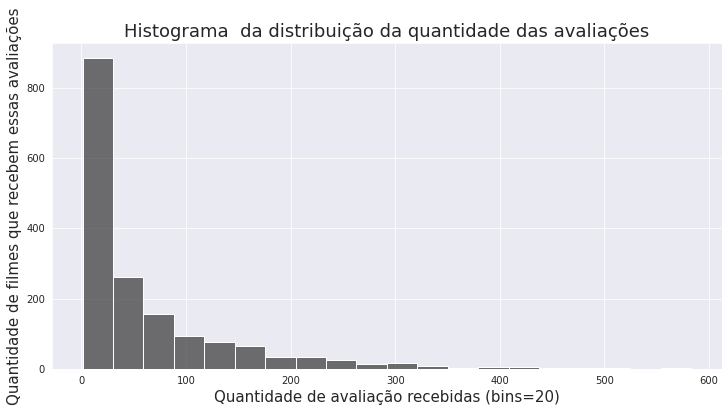

In [22]:
plt.figure(figsize=(12,6))
sns.histplot(dataset_agrupado['count'], bins=20, color= '#404040')
plt.title('Histograma  da distribuição da quantidade das avaliações', fontsize= 18)
plt.xlabel('Quantidade de avaliação recebidas (bins=20)', fontsize= 15)
plt.ylabel('Quantidade de filmes que recebem essas avaliações', fontsize= 15)
plt.savefig('Histograma_qtr_avaliação.png', dpi=400, bbox_inches='tight')
plt.show()

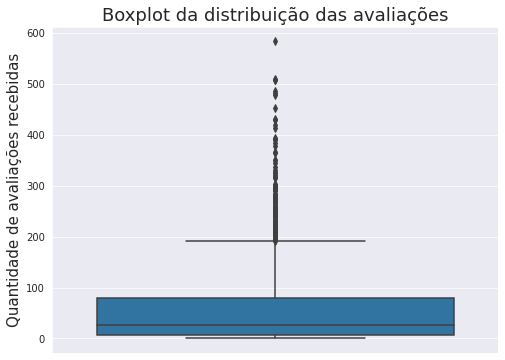

In [23]:
plt.figure(figsize=(8,6))
sns.boxplot(y= 'count', data= dataset_agrupado)
plt.title('Boxplot da distribuição das avaliações', fontsize=18)
plt.ylabel('Quantidade de avaliações recebidas', fontsize=15)
plt.show()

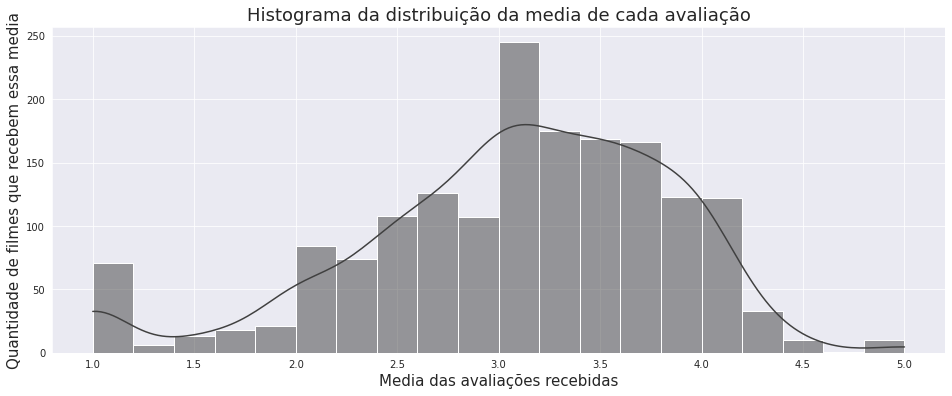

In [24]:
plt.figure(figsize=(16,6))
sns.histplot(dataset_agrupado['mean'], bins=20, kde=True, color= '#404040')
plt.title('Histograma da distribuição da media de cada avaliação', fontsize=18)
plt.ylabel('Quantidade de filmes que recebem essa media', fontsize=15)
plt.xlabel('Media das avaliações recebidas', fontsize=15)
plt.savefig('Histograma_media_avaliação.png', dpi=400, bbox_inches='tight')
plt.show()

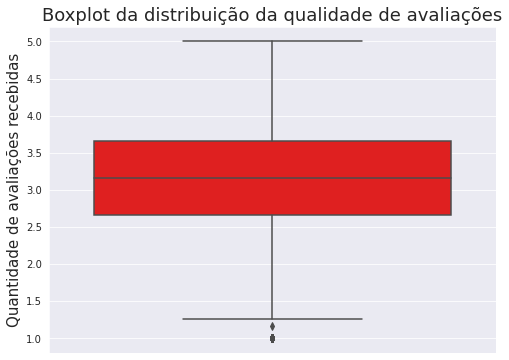

In [25]:
plt.figure(figsize=(8,6))
sns.boxplot(y= 'mean', data= dataset_agrupado, color= 'red')
plt.title('Boxplot da distribuição da qualidade de avaliações', fontsize=18)
plt.ylabel('Quantidade de avaliações recebidas', fontsize= 15)
plt.show()

In [26]:
dataset_agrupado.median()

id_filme    841.500000
count        27.000000
mean          3.161528
dtype: float64

In [27]:
dataset_agrupado = dataset_agrupado.reset_index().merge(dataset_item, left_on='id_filme', right_on='id_filme', how='left')

In [28]:
dataset_agrupado['id_filme'] = dataset_agrupado['id_filme'].astype(str)

In [29]:
dataset['id_filme'] = dataset['id_filme'].astype(int)

In [30]:
dataset_item['id_filme'] = dataset_item['id_filme'].astype(int)

In [31]:
dataset_agrupado['id_filme'] = dataset_agrupado['id_filme'].astype(int)

In [32]:
dataset_agrupado = dataset_agrupado.reset_index().merge(dataset_item, left_on='id_filme', right_on='id_filme', how='left')

In [33]:
dataset_agrupado[['nome_filme_x', 'count']].sort_values(by='count', ascending=False).head(10)

,nome_filme_x,count
1128,Star Wars (1977),583
859,Contact (1997),509
2,Fargo (1996),508
774,Return of the Jedi (1983),507
899,Liar Liar (1997),485
890,"English Patient, The (1996)",481
892,Scream (1996),478
0,Toy Story (1995),452
907,Air Force One (1997),431
235,Independence Day (ID4) (1996),429


In [34]:
dataset_agrupado[dataset_agrupado['count']> 50][['nome_filme_x', 'mean', 'count']].sort_values(by='mean', ascending=False).head(10)

,nome_filme_x,mean,count
1026,"Close Shave, A (1995)",4.491071,112
926,Schindler's List (1993),4.466443,298
760,"Wrong Trousers, The (1993)",4.466102,118
1109,Casablanca (1942),4.456790,243
157,Wallace & Gromit: The Best of Aardman Animatio...,4.447761,67
1283,"Shawshank Redemption, The (1994)",4.445230,283
1243,Rear Window (1954),4.387560,209
223,"Usual Suspects, The (1995)",4.385768,267
1128,Star Wars (1977),4.358491,583
770,12 Angry Men (1957),4.344000,125


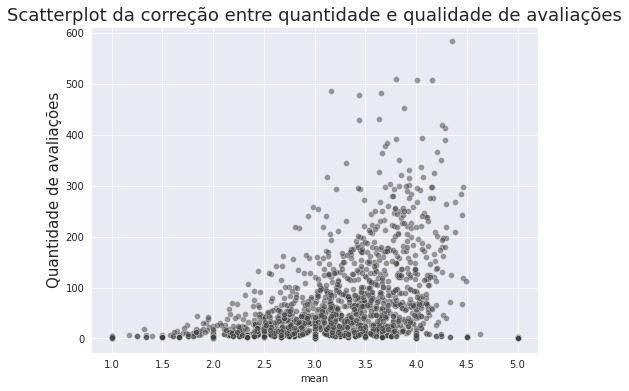

In [35]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='mean', y='count', data= dataset_agrupado, alpha=0.5, color='#404040')
plt.title('Scatterplot da correção entre quantidade e qualidade de avaliações', fontsize=18)
plt.ylabel('Media das avaliações', fontsize=15)
plt.ylabel('Quantidade de avaliações', fontsize=15)
plt.savefig('cor_qrt_media.png', dpi=400, bbox_inches='tight')
plt.show()

In [36]:
dataset_agrupado[['mean', 'count']].corr()

,mean,count
mean,1.000000,0.429659
count,0.429659,1.000000


In [37]:
cols = dataset_agrupado.columns[6: ]
dict_cols = {coluna:0 for coluna in cols}
for i in dataset_agrupado.index:
  for coluna in cols:
    if(dataset_agrupado.iloc[i][coluna] == 1):
      dict_cols[coluna] += dataset_agrupado.iloc[i]['count']
dict_cols = {k: v for k,v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}

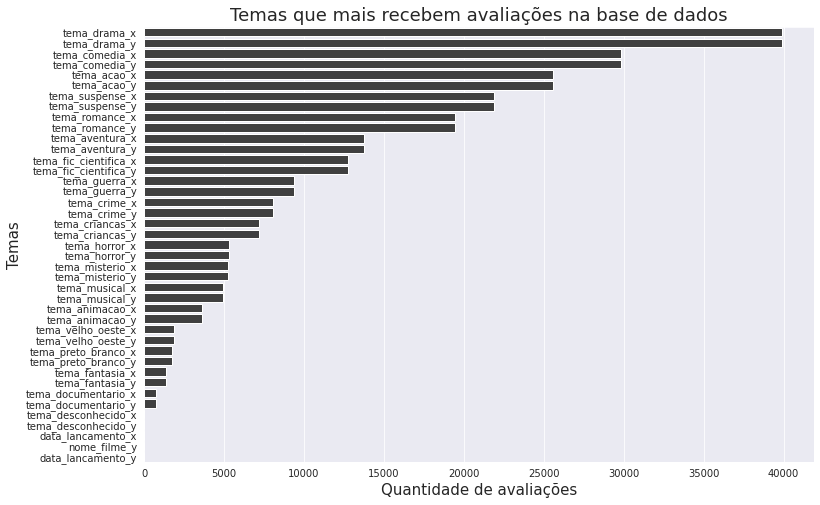

In [38]:
plt.figure(figsize=(12,8))
plt.title('Temas que mais recebem avaliações na base de dados', fontsize=18)
plt.ylabel('Temas', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style='darkgrid')
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()), color='#404040')

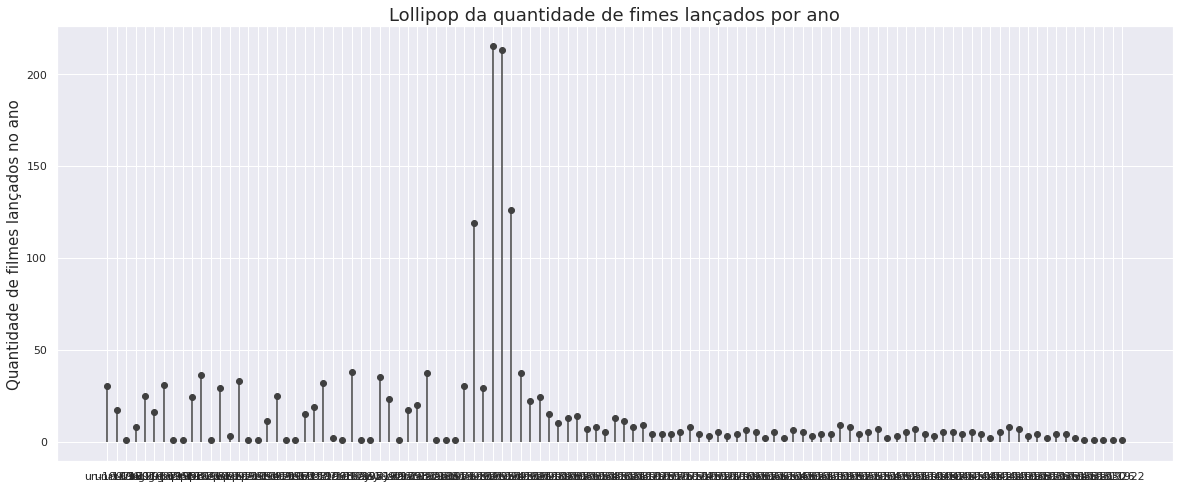

In [39]:
dataset_item['year'] = dataset_item['data_lancamento'].str[4:]
g = dataset_item[['year', 'id_filme']].groupby(by='year').count().to_dict()
g = g['id_filme']
fig, ax = plt.subplots(figsize=(20,8))
x = list(g.keys())[::-1]
y = list(g.values())[::-1]
ax.vlines(x, ymin=0, ymax=y, color='#404040')
ax.plot(x,y, 'o', color='#404040')
ax.set_ylabel('Quantidade de filmes lançados no ano', fontsize=15)
ax.set_title('Lollipop da quantidade de fimes lançados por ano', fontsize=18)
plt.savefig('Lollipop_qtr_ano.png', dpi=400, bbox_inches='tight')
plt.show()

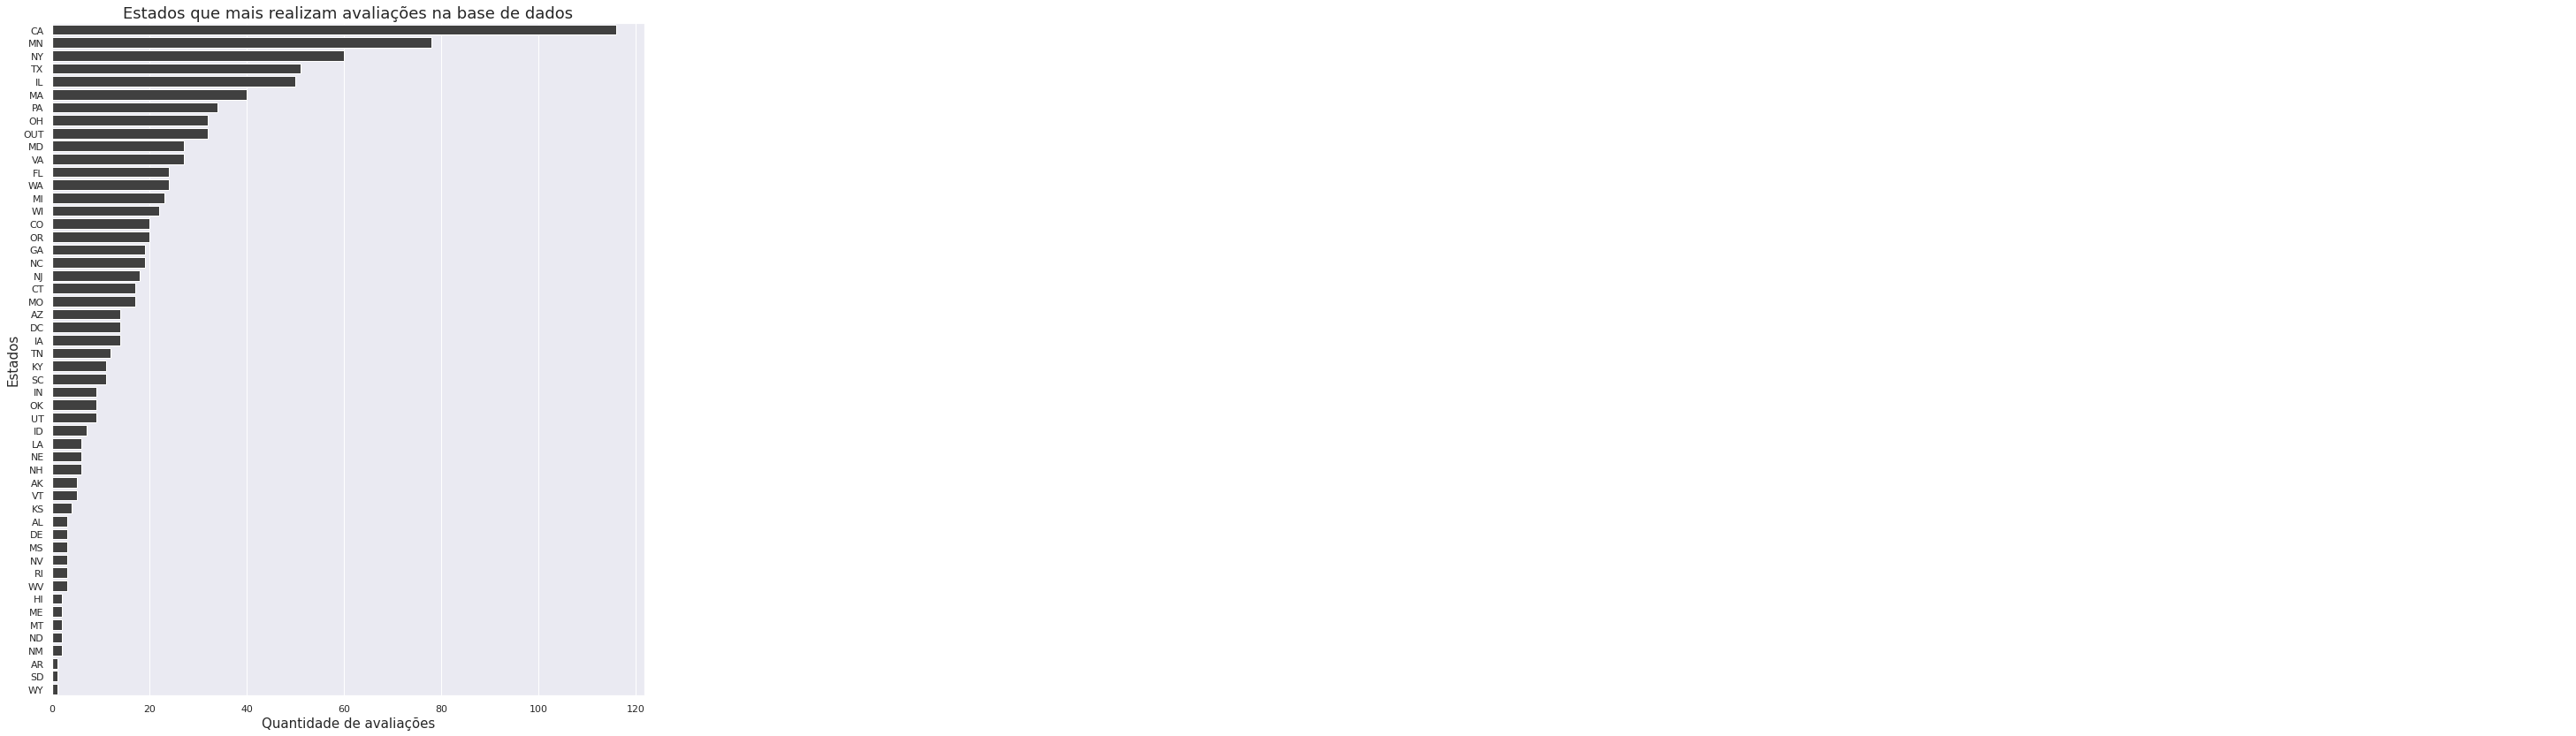

In [40]:
dict_cols = dataset_usuarios.groupby(by='estado_usa').count().to_dict()['id_usuario']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}
plt.figure(figsize=(12,14))
plt.title('Estados que mais realizam avaliações na base de dados', fontsize=18)
plt.ylabel('Estados', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style='darkgrid')
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()), color='#404040')
for p in ax.patches:
  ax.annotate(format(p.get_width(), '.0f'),
                (p.get_width() + 400, (p.get_height()) + p.get_y()),
                ha = 'center', va= 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.savefig('estados_avaliadores.png', dpi=400, bbox_inches='tight')
plt.show()

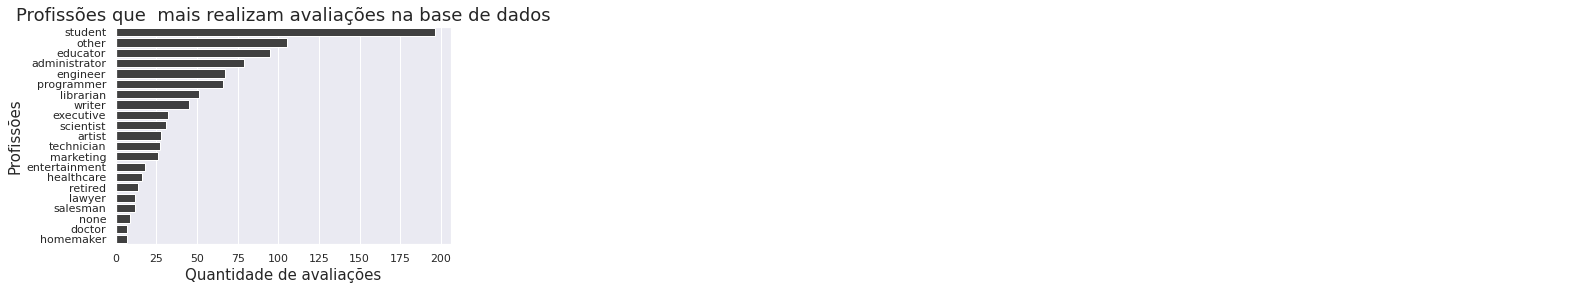

In [41]:
dict_cols = dataset_usuarios.groupby(by='profissao').count().to_dict()['id_usuario']
dict_cols = {k: v for k, v in sorted(dict_cols.items(), key=lambda item: item[1], reverse=True)}
plt.title('Profissões que  mais realizam avaliações na base de dados', fontsize=18)
plt.ylabel('Profissões', fontsize=15)
plt.xlabel('Quantidade de avaliações', fontsize=15)
sns.set(style='darkgrid')
ax = sns.barplot(x=list(dict_cols.values()), y=list(dict_cols.keys()), color='#404040')
for p in ax.patches:
  ax.annotate(format(p.get_width(), '.0f'),
                (p.get_width() + 700, (p.get_height()) +p.get_y()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')
plt.savefig('profissão_avaliadores.png', dpi=400, bbox_inches= 'tight')
plt.show()

In [42]:
if (1==1): 
  dataset = dataset.sample(frac=1, random_state=42)
  dataset_aux = pd.DataFrame(columns=dataset.columns)
  dataset_test = pd.DataFrame(columns=dataset.columns)
  dataset_train = pd.DataFrame(columns=dataset.columns)

  dataset_contagem = pd.DataFrame(dataset.groupby(by=['id_usuario']).count()['id_filme']).reset_index()
  dataset_contagem.head()

  for i, rowi in dataset_contagem.iterrows():
    num_avals = rowi['id_filme']
    test_size = round(num_avals*0.3)

    if test_size >= 10:
      dataset_test = dataset_test.append(dataset[dataset['id_usuario']==rowi['id_usuario']].iloc[:test_size])
      dataset_train = dataset_train.append(dataset[dataset['id_usuario']==rowi['id_usuario']].iloc[test_size:])

  dataset_train['idade'] = dataset_train.idade.astype(int)
  dataset_train['avaliacao'] = dataset_train.avaliacao.astype(int)
else:
  dataset_train, dataset_test = train_test_split(dataset, test_size=0.30, random_state=42)

In [43]:
dataset_train.shape[0] + dataset_test.shape[0]

94601

In [44]:
def wr_imdb(dataframe, nome_coluna_avaliacoes='avaliacao', nome_coluna_id_filme='id_filme', percentil_minimo_avaliacoes=0.9):  
  dataframe_auxiliar = dataframe[[nome_coluna_id_filme,nome_coluna_avaliacoes]].groupby(by=nome_coluna_id_filme).agg(['count','mean'])[nome_coluna_avaliacoes].reset_index()
    
  C = dataframe[nome_coluna_avaliacoes].mean()
  m = dataframe_auxiliar['count'].quantile(percentil_minimo_avaliacoes)
    
  lista_auxiliar = []
  for i in dataframe_auxiliar.index:
      if (dataframe_auxiliar.iloc[i]['count'] < m):
          lista_auxiliar.append(1)
      else:
          R = dataframe_auxiliar.iloc[i]['mean']
          v = dataframe_auxiliar.iloc[i]['count']
          lista_auxiliar.append( ( R*v + C*m ) / (v+m) )
    
  dataframe_auxiliar['popularidade'] = lista_auxiliar
    
  return dataframe_auxiliar[[nome_coluna_id_filme,'popularidade']].copy()    

In [45]:
dataset_resultado_popularidade = wr_imdb(dataset_train)


In [46]:
dataset_resultado_popularidade.merge(dataset_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
49,50,4.188636,Star Wars (1977)
317,318,4.136216,Schindler's List (1993)
63,64,4.107815,"Shawshank Redemption, The (1994)"
482,483,4.084330,Casablanca (1942)
126,127,4.079559,"Godfather, The (1972)"
97,98,4.076002,"Silence of the Lambs, The (1991)"
11,12,4.061401,"Usual Suspects, The (1995)"
173,174,4.046815,Raiders of the Lost Ark (1981)
601,603,3.992505,Rear Window (1954)
171,172,3.991765,"Empire Strikes Back, The (1980)"


In [47]:
def current_wr_imdb(dataframe, nome_coluna_avaliacoes='avaliacao', nome_coluna_id_filme='id_filme', percentil_minimo_avaliacoes=0.9, periodo_maximo_considerado=30, nome_coluna_data_avaliacao='data_avaliacao'):  
  dataframe_auxiliar = dataframe.copy()
  dataframe_auxiliar[nome_coluna_data_avaliacao] = pd.to_datetime(dataframe_auxiliar[nome_coluna_data_avaliacao])
  dataframe_auxiliar = dataframe_auxiliar[dataframe_auxiliar[nome_coluna_data_avaliacao] >=  dataframe_auxiliar[nome_coluna_data_avaliacao].max() - pd.Timedelta(days=periodo_maximo_considerado)].copy()
    
  return wr_imdb(dataframe_auxiliar, nome_coluna_avaliacoes, nome_coluna_id_filme, percentil_minimo_avaliacoes)

In [48]:
from pandas.core.frame import DataFrame
def search_theme(dataset_interaçoes, dataframe_filme, theme):
  if(theme not in dataframe_filme.columns):
    print('Erro: O tema que você está procurando não foi encontrado')
    return DataFrame()
  else:
    dataframe_filme['filtro'] = True
    dataframe_interaçoes = dataset_interaçoes.merge(dataframe_filme[dataframe_filme[theme] == 1] [['id_filme', 'filtro']], left_on='id_filme', right_on='id_filme', how='left')
    return dataframe_interaçoes[dataframe_interaçoes['filtro'].notna()].copy()

In [49]:
current_wr_imdb(search_theme(dataset_train, dataset_item, "tema_criancas")).merge(dataset_item[['id_filme','nome_filme']],
                                                                  left_on='id_filme', right_on='id_filme', 
                                                                  how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
13,132,3.941062,"Wizard of Oz, The (1939)"
55,588,3.806828,Beauty and the Beast (1991)
40,423,3.767824,E.T. the Extra-Terrestrial (1982)
42,432,3.764012,Fantasia (1940)
9,99,3.669055,Snow White and the Seven Dwarfs (1937)
37,419,3.636925,Mary Poppins (1964)
1,8,3.636925,Babe (1995)
19,151,3.610182,Willy Wonka and the Chocolate Factory (1971)
4,71,3.564109,"Lion King, The (1994)"
8,95,3.539837,Aladdin (1992)


In [50]:
dataset_usuarios.head(10)

,id_usuario,idade,sexo,profissao,cep,estado_usa
0,1,24,M,technician,85711,AZ
1,2,53,F,other,94043,CA
2,3,23,M,writer,32067,FL
3,4,24,M,technician,43537,OH
4,5,33,F,other,15213,PA
5,6,42,M,executive,98101,WA
6,7,57,M,administrator,91344,CA
7,8,36,M,administrator,05201,VT
8,9,29,M,student,01002,MA
9,10,53,M,lawyer,90703,CA


In [51]:
dataset_clusting = pd.get_dummies(dataset_usuarios[['id_usuario', 'sexo', 'profissao', 'estado_usa']])
dataset_clusting.head()

,id_usuario_1,id_usuario_10,id_usuario_100,id_usuario_101,id_usuario_102,id_usuario_103,id_usuario_104,id_usuario_105,id_usuario_106,id_usuario_107,...,estado_usa_SD,estado_usa_TN,estado_usa_TX,estado_usa_UT,estado_usa_VA,estado_usa_VT,estado_usa_WA,estado_usa_WI,estado_usa_WV,estado_usa_WY
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


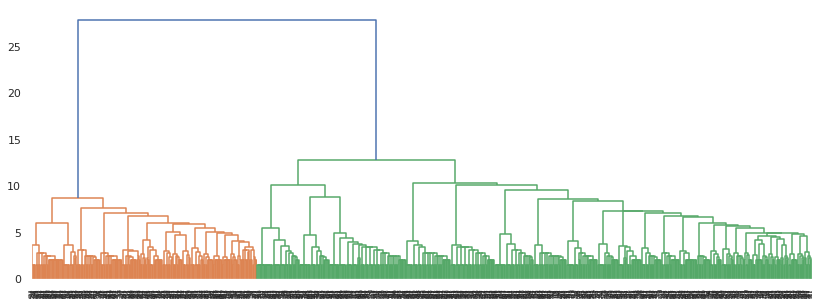

In [52]:
plt.figure(figsize=(14,5))
mergins = linkage(dataset_clusting, method='ward', metric='euclidean')
dendrogram(mergins)
plt.savefig('dendogram_png', dpi=400, bbox_inches='tight')
plt.show(True)

In [53]:
for i in range(2,20):
  dataset_clusting['ClusterHWard'] = cut_tree(mergins, n_clusters=i).reshape(-1, )
  print(i, " - Ward's Silhouette score:", silhouette_score(dataset_clusting, dataset_clusting['ClusterHWard'], metric='euclidean'))

2  - Ward's Silhouette score: 0.1903412361197277
3  - Ward's Silhouette score: 0.1993410030219412
4  - Ward's Silhouette score: 0.1867274102234031
5  - Ward's Silhouette score: 0.18995497766934197
6  - Ward's Silhouette score: 0.19295997689806346
7  - Ward's Silhouette score: 0.19463619431571808
8  - Ward's Silhouette score: 0.19938638959868268
9  - Ward's Silhouette score: 0.2076792396637109
10  - Ward's Silhouette score: 0.21042679838509223
11  - Ward's Silhouette score: 0.21114483310623952
12  - Ward's Silhouette score: 0.21957992585417122
13  - Ward's Silhouette score: 0.22118423405344148
14  - Ward's Silhouette score: 0.22119155378813607
15  - Ward's Silhouette score: 0.22712585450956396
16  - Ward's Silhouette score: 0.21492062359503458
17  - Ward's Silhouette score: 0.22352042476117873
18  - Ward's Silhouette score: 0.2272293795049259
19  - Ward's Silhouette score: 0.2275404344650294


In [54]:
dataset_usuarios['grupo'] = cut_tree(mergins, n_clusters=10).reshape(-1, )

In [55]:
dataset_usuarios.head()

,id_usuario,idade,sexo,profissao,cep,estado_usa,grupo
0,1,24,M,technician,85711,AZ,0
1,2,53,F,other,94043,CA,1
2,3,23,M,writer,32067,FL,0
3,4,24,M,technician,43537,OH,0
4,5,33,F,other,15213,PA,1


In [56]:
def get_recommendations_clusterized(iid_usuario, dataframe_usuarios, dataframe, nome_coluna_id_usuario='id_usuario', nome_coluna_id_filme='id_filme', nome_coluna_grupo='grupo'):
  dataframe_auxiliar = dataframe.copy()
  dataframe_auxiliar_usuarios = dataframe_usuarios.copy()
  grp = list(dataframe_auxiliar_usuarios[dataframe_auxiliar_usuarios[nome_coluna_id_usuario]==str(iid_usuario)][nome_coluna_grupo])[0]
  dataframe_auxiliar = dataframe_auxiliar.merge(dataframe_auxiliar_usuarios[dataframe_auxiliar_usuarios[nome_coluna_grupo]==grp][[nome_coluna_id_usuario,nome_coluna_grupo]], left_on=nome_coluna_id_usuario, right_on=nome_coluna_id_usuario, how='left')
  dataframe_auxiliar = dataframe_auxiliar[dataframe_auxiliar[nome_coluna_grupo].notna()]
    
  dataframe_auxiliar_ = dataframe_auxiliar[[nome_coluna_id_usuario,nome_coluna_id_filme]].copy()
  dataframe_auxiliar_.columns = ['iid_usuario','iid_filme']
  dataframe_auxiliar_ = dataframe_auxiliar_[dataframe_auxiliar_['iid_usuario']==str(iid_usuario)]
  dataframe_auxiliar = dataframe_auxiliar.merge(dataframe_auxiliar_, how='left', left_on=nome_coluna_id_filme, right_on='iid_filme')
  dataframe_auxiliar = dataframe_auxiliar[dataframe_auxiliar['iid_filme'].isna()]
  dataframe_auxiliar.drop(columns=['iid_filme','iid_usuario'], inplace=True)

  return dataframe_auxiliar

In [57]:
dataset_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized('2', dataset_usuarios, dataset_train))
dataset_resultado_popularidade_atual.merge(dataset_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
384,496,4.258583,It's a Wonderful Life (1946)
459,603,4.157439,Rear Window (1954)
180,213,4.113465,"Room with a View, A (1986)"
374,485,4.104737,My Fair Lady (1964)
330,427,4.104737,To Kill a Mockingbird (1962)
452,588,4.097256,Beauty and the Beast (1991)
372,483,4.085099,Casablanca (1942)
244,318,4.075643,Schindler's List (1993)
9,12,4.030132,"Usual Suspects, The (1995)"
96,124,4.030132,Lone Star (1996)


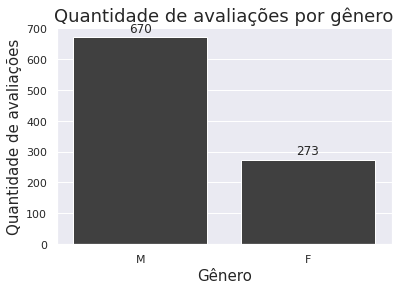

In [58]:
df_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized('2', dataset_usuarios, dataset_train))
plt.figure()
ax = sns.countplot(x='sexo', data=dataset_usuarios, color='#404040')
sns.set(style='darkgrid', rc={'figure.figsize': (12,8)})
plt.title('Quantidade de avaliações por gênero', fontsize=18)
plt.ylabel('Quantidade de avaliações', fontsize=15)
plt.xlabel('Gênero', fontsize=15)
for p in ax.patches:
   ax.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')

plt.savefig("genero_avaliadores.png",dpi=400, bbox_inches='tight')
plt.show()

In [59]:
dataset_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized('3', dataset_usuarios, dataset_train))

In [60]:
dataset_resultado_popularidade_atual.merge(dataset_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(10)

,id_filme,popularidade,nome_filme
41,50,4.361594,Star Wars (1977)
116,134,4.266289,Citizen Kane (1941)
110,127,4.222811,"Godfather, The (1972)"
388,484,4.217087,"Maltese Falcon, The (1941)"
387,483,4.204986,Casablanca (1942)
176,199,4.173591,"Bridge on the River Kwai, The (1957)"
419,515,4.164455,"Boot, Das (1981)"
286,357,4.106232,One Flew Over the Cuckoo's Nest (1975)
168,191,4.101174,Amadeus (1984)
117,135,4.088527,2001: A Space Odyssey (1968)


In [61]:
reader = Reader(rating_scale=(1, 5))
svd = SVD()

In [62]:
data = Dataset.load_from_df(dataset_train[['id_usuario', 'id_filme', 'avaliacao']], reader)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9508  0.9544  0.9499  0.9517  0.0020  
MAE (testset)     0.7539  0.7550  0.7503  0.7531  0.0020  
Fit time          2.64    3.55    2.64    2.95    0.43    
Test time         0.34    0.16    0.19    0.23    0.08    


{'test_rmse': array([0.95080572, 0.95443767, 0.94991574]),
 'test_mae': array([0.75385451, 0.75503407, 0.7503044 ]),
 'fit_time': (2.644171714782715, 3.55148983001709, 2.6442747116088867),
 'test_time': (0.3381383419036865, 0.16180968284606934, 0.1902763843536377)}

In [63]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [64]:
svd.predict('2', '296').est

3.6559617820621546

In [65]:
dataset_resultado_popularidade_atual = current_wr_imdb(get_recommendations_clusterized('2', dataset_usuarios, dataset_train))
dataset_resultado_popularidade_atual.merge(dataset_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left').sort_values(by='popularidade', ascending=False).head(3)

,id_filme,popularidade,nome_filme
384,496,4.258583,It's a Wonderful Life (1946)
459,603,4.157439,Rear Window (1954)
180,213,4.113465,"Room with a View, A (1986)"


In [66]:
svd.predict('2', '357').est

3.6559617820621546

In [67]:
svd.predict('2', '528').est

3.6559617820621546

In [68]:
def get_recommendations_collaborative_filtering(iid_usuario, dataframe_svd, dataframe_filmes, dataframe, n=5, nome_coluna_id_filme='id_filme', nome_coluna_id_usuario = 'id_usuario'):  
  films_list = list(dataframe_filmes[nome_coluna_id_filme].unique())
  score_list = []
    
  for f in films_list:
    score_list.append(dataframe_svd.predict(str(iid_usuario), str(f)).est)
        
    dataframe_output = pd.DataFrame([str(iid_usuario)]*len(films_list), columns=[nome_coluna_id_usuario])
    dataframe_output[nome_coluna_id_filme] = films_list
    dataframe_output['avaliacao'] = score_list
    dataframe_output = dataframe_output.sort_values(by='avaliacao',ascending=False)
    dataset_aux = dataframe[dataframe[nome_coluna_id_usuario]==iid_usuario][[nome_coluna_id_filme, 'data_avaliacao']]
    dataframe_output = dataframe_output.merge(dataset_aux, how='left', left_on=nome_coluna_id_filme, right_on=nome_coluna_id_filme)
    dataframe_output = dataframe_output[dataframe_output['data_avaliacao'].isna()]
    dataframe_output.drop(columns=['data_avaliacao'],inplace=True)

    return dataframe_output.head(n)

In [73]:
dataset_resultado_filtragem_colaborativa = get_recommendations_collaborative_filtering('2',svd,dataset_item, dataset_train, 10)
dataset_resultado_filtragem_colaborativa.merge(dataset_item[['id_filme','nome_filme']], left_on='id_filme', right_on='id_filme', how='left')

ValueError: ignored

In [ ]:
def get_genres(iid_filme, dataframe_filme, columns, nome_coluna_id_filme='id_filme') :
  genres_list = list()
  dataframe_line = dataframe_filme[dataframe_filme[nome_coluna_id_filme]== iid_filme]
  for col in columns:
    if dataframe_line[col].values[0] == 1:
      genres_list.append(col)
  return genres_list

In [ ]:
def generate_graph(dataframe, dataframe_filmes, dataframe_usuarios, nome_coluna_id_filme='id_filme', nome_coluna_id_usuaio='id_usuario', nome_coluna_grupo='grupo', nome_coluna_ano='year'):  
  G_ = nx.Graph(label="MOVIE")
  for i, rowi in dataframe.iterrows():
    G_.add_node(rowi[nome_coluna_id_filme],label="FILME")
    G_.add_node("user_"+rowi[nome_coluna_id_usuaio],label="USUARIO")
    G_.add_edge(rowi[nome_coluna_id_filme], "user_"+rowi[nome_coluna_id_usuaio], label="ASSISTIU")

  df_aux = dataframe.merge(dataframe_usuarios[[nome_coluna_id_usuaio,'grupo']], how='left', left_on=nome_coluna_id_usuaio, right_on=nome_coluna_id_usuaio)[[nome_coluna_id_filme,nome_coluna_grupo]].drop_duplicates()
  dicio_cluster = dict()
  for i, rowi in df_aux.iterrows():
    G_.add_node("group_"+str(rowi[nome_coluna_grupo]),label="GRUPO")
    G_.add_edge(rowi[nome_coluna_id_filme], "group_"+str(rowi[nome_coluna_grupo]), label="GRUPO")

  for i, rowi in dataframe_filmes.iterrows():
    if rowi[nome_coluna_id_filme] in G_.nodes:
      for subject in get_genres(rowi[nome_coluna_id_filme],dataframe_filmes, temas):
        G_.add_node(subject,label="TEMA")
        G_.add_edge(rowi[nome_coluna_id_filme], subject, label="TEMA")

        ano = rowi[nome_coluna_ano]
        G_.add_node("year_"+str(ano),label="ANO")
        G_.add_edge(rowi[nome_coluna_id_filme], "year_"+str(ano), label="ANO")

  return G_

In [ ]:
G = generate_graph(dataset_train, dataset_item, dataset_usuarios)

In [ ]:
def get_recommendation_from_graph(G_, root):
  commons_dict = {}
  for e in G_.neighbors(root):
      for e2 in G_.neighbors(e):
          if e2==root:
              continue
          if G_.nodes[e2]['label']=="FILME":
              commons = commons_dict.get(e2)
              if commons==None:
                  commons_dict.update({e2 : [e]})
              else:
                  commons.append(e)
                  commons_dict.update({e2 : commons})
      movies=[]
      weight=[]
      for key, values in commons_dict.items():
          w=0.0
          for e in values:
            w=w+1/math.log(G_.degree(e))
          movies.append(key) 
          weight.append(w)
    
      result = pd.Series(data=np.array(weight),index=movies)
      result.sort_values(inplace=True,ascending=False)        
      return result

In [ ]:
G = generate_graph(dataset_train, dataset_item, dataset_usuarios)

In [ ]:
def get_all_adj_nodes(G_, list_in):
  sub_graph=set()
  for m in list_in:
      sub_graph.add(m)
      for e in G_.neighbors(m):        
              sub_graph.add(e)
  return list(sub_graph)

def draw_sub_graph(G_, sub_graph):
  
    subgraph = G_.subgraph(sub_graph)
    pos = nx.spring_layout(G_, seed=5)
    colors=[]
    for e in subgraph.nodes():
        if G_.nodes[e]['label']=="FILME":
            colors.append('blue')
        elif G_.nodes[e]['label']=="USUARIO":
            colors.append('red')
        elif G_.nodes[e]['label']=="TEMA":
            colors.append('yellow')
        elif G_.nodes[e]['label']=="ANO":
            colors.append('orange')
        elif G_.nodes[e]['label']=="GRUPO":
            colors.append('green')
    nx.draw(subgraph,pos=pos, with_labels=True, font_weight='bold',node_color=colors)
    plt.savefig("grafo.png",dpi=400, bbox_inches='tight')
    plt.show()

In [ ]:
def adamic_adar_rec1(G_, dataframe, dataframe_filmes, n=20, nome_coluna_id_usuario='id_usuario', nome_coluna_id_filme = 'id_filme'):  
  dataset_item_proximity = pd.DataFrame(columns=['id_filme_proximo', 'adamic_adar','id_filme'])
  dataset_retorno = pd.DataFrame(columns=['id_usuario','recomendacoes'])
  for filme in dataframe_filmes[nome_coluna_id_filme]:
    if filme in dataframe[nome_coluna_id_filme].unique():
      dataset_aux = pd.DataFrame(get_recommendation_from_graph(G_, filme).head(10)).reset_index()
      dataset_aux['id_filme'] = filme
      dataset_aux.columns = ['id_filme_proximo', 'adamic_adar','id_filme']
      dataset_item_proximity = dataset_item_proximity.append(dataset_aux, ignore_index=True)

  
  for usuario in dataframe[nome_coluna_id_usuario].unique():
    dataset_aux = dataframe[dataframe[nome_coluna_id_usuario]==usuario].sort_values(by=['data_avaliacao'],ascending=[False]).head(n)
    dataset_aux = dataset_aux.merge(dataset_item_proximity, how='left', left_on=nome_coluna_id_filme,right_on=nome_coluna_id_filme)
    dataset_aux = dataset_aux.sort_values(by='adamic_adar',ascending=False)
    dataset_aux = dataset_aux.drop_duplicates(subset=['id_filme_proximo'])
    dataset_aux = dataset_aux.merge(dataframe[dataframe[nome_coluna_id_usuario]==usuario][[nome_coluna_id_filme]], how='left', left_on='id_filme_proximo',right_on=nome_coluna_id_filme)
    dataset_aux = dataset_aux[dataset_aux[nome_coluna_id_filme + '_y'].isna()]

    
    if len(list(dataset_aux.head(10).id_filme_proximo)) == 10:
      dataset_retorno = dataset_retorno.append(pd.DataFrame([[usuario,list(dataset_aux.head(10).id_filme_proximo)]],columns=['id_usuario','recomendacoes']), ignore_index=True)
    else:
      dataset_aux = dataframe[dataframe[nome_coluna_id_usuario]==usuario].sort_values(by=['data_avaliacao'],ascending=[False]).head(n+10)
      dataset_aux = dataset_aux.merge(dataset_item_proximity, how='left', left_on=nome_coluna_id_filme,right_on=nome_coluna_id_filme)
      dataset_aux = dataset_aux.sort_values(by='adamic_adar',ascending=False)
      dataset_aux = dataset_aux.drop_duplicates(subset=['id_filme_proximo'])
      dataset_aux = dataset_aux.merge(dataframe[dataframe[nome_coluna_id_usuario]==usuario][[nome_coluna_id_filme]], how='left', left_on='id_filme_proximo',right_on=nome_coluna_id_filme)
      dataset_aux = dataset_aux[dataset_aux[nome_coluna_id_filme + '_y'].isna()]
      dataset_retorno = dataset_retorno.append(pd.DataFrame([[usuario,list(dataset_aux.head(10).id_filme_proximo)]],columns=['id_usuario','recomendacoes']), ignore_index=True)

  return dataset_retorno

In [ ]:
def adamic_adar_ordered(G_, dataframe, dataframe_filmes, dataframe_svd, n=20, nome_coluna_id_usuario='id_usuario', nome_coluna_id_filme = 'id_filme'):  
  dataset_item_proximity = pd.DataFrame(columns=['id_filme_proximo', 'adamic_adar','id_filme'])
  dataset_retorno = pd.DataFrame(columns=['id_usuario','recomendacoes'])

  for filme in dataframe_filmes[nome_coluna_id_filme]:
    if filme in dataframe[nome_coluna_id_filme].unique():
      dataset_aux = pd.DataFrame(get_recommendation_from_graph(G_, filme).head(10)).reset_index()
      dataset_aux['id_filme'] = filme
      dataset_aux.columns = ['id_filme_proximo', 'adamic_adar','id_filme']
      dataset_item_proximity = dataset_item_proximity.append(dataset_aux, ignore_index=True)
  
  for usuario in dataframe[nome_coluna_id_usuario].unique():
    dataset_aux = dataframe[dataframe[nome_coluna_id_usuario] == usuario].sort_values(by=['data_avaliacao'], ascending= [False]).head(n)
    dataset_aux = dataset_aux.merge(dataset_item_proximity, how='left', left_on= nome_coluna_id_filme, right_on=nome_coluna_id_filme)
    films_list = list(dataset_aux[nome_coluna_id_filme])
    score_list = []


  for usuario in dataframe[nome_coluna_id_usuario].unique():
    dataset_aux = dataframe[dataframe[nome_coluna_id_usuario]==usuario].sort_values(by=['data_avaliacao'],ascending=[False]).head(n)
    dataset_aux = dataset_aux.merge(dataset_item_proximity, how='left', left_on=nome_coluna_id_filme,right_on=nome_coluna_id_filme)
    films_list = list(dataset_aux[nome_coluna_id_filme])
    score_list = []
    
  for f in films_list:
      score_list.append(dataframe_svd.predict(str(usuario), str(f)).est)
  dataset_aux['score'] = score_list
  dataset_aux = dataset_aux.sort_values(by='score',ascending=False)
  dataset_aux = dataset_aux.drop_duplicates(subset=['id_filme_proximo'])
  dataset_aux = dataset_aux.merge(dataframe[dataframe[nome_coluna_id_usuario]==usuario][[nome_coluna_id_filme]], how='left', left_on='id_filme_proximo',right_on=nome_coluna_id_filme)
  dataset_aux = dataset_aux[dataset_aux[nome_coluna_id_filme + '_y'].isna()]

  if len(list(dataset_aux.head(10).id_filme_proximo)) == 10:
    dataset_retorno = dataset_retorno.append(pd.DataFrame([[usuario,list(dataset_aux.head(10).id_filme_proximo)]],columns=['id_usuario','recomendacoes']), ignore_index=True)
  else:
    dataset_aux = dataframe[dataframe[nome_coluna_id_usuario]==usuario].sort_values(by=['data_avaliacao'],ascending=[False]).head(n+10)
    dataset_aux = dataset_aux.merge(dataset_item_proximity, how='left', left_on=nome_coluna_id_filme,right_on=nome_coluna_id_filme)
    score_list = []

  films_list = list(dataset_aux[nome_coluna_id_filme])
  score_list = []
  for f in films_list:
    score_list.append(dataframe_svd.predict(str(usuario), str(f)).est)
  dataset_aux['score'] = score_list
  dataset_aux = dataset_aux.sort_values(by='score',ascending=False)
  dataset_aux = dataset_aux.drop_duplicates(subset=['id_filme_proximo'])
  dataset_aux = dataset_aux.merge(dataframe[dataframe[nome_coluna_id_usuario]==usuario][[nome_coluna_id_filme]], how='left', left_on='id_filme_proximo',right_on=nome_coluna_id_filme)
  dataset_aux = dataset_aux[dataset_aux[nome_coluna_id_filme + '_y'].isna()]

  dataset_retorno = dataset_retorno.append(pd.DataFrame([[usuario,list(dataset_aux.head(10).id_filme_proximo)]],columns=['id_usuario','recomendacoes']), ignore_index=True)
  return dataset_retorno

In [ ]:
def apk(actual, predicted, k=10, func_type= 'ordered_precition'):
    if len(str(predicted))>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    if not actual or actual!=actual:
        return 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if (func_type == 'precision'):
      return num_hits / min(len(actual), k)
    elif (func_type == 'ordered_precision'):
      return score / min(len(actual), k)

In [ ]:
def mapk(actual, predicted, k=10, func_type = 'ordered_precision'):  
  return np.mean([apk(a,p,k, func_type) for a,p in zip(actual, predicted)])

In [ ]:
def predicted_coverage(predicted, catalog):
  predicted_flattend = [p for sublist in predicted for p in sublist]
  unique_predictions = len(set(predicted_flattend))
  predicted_coverage = round(unique_predictions/(len(catalog) * 1.0) *100,4)
  return predicted_coverage

In [ ]:
def personalization(predicted):
  def make_rec_matrix(predicted):
    dataset_aux = pd.DataFrame(data=predicted).reset_index().melt(id_vars='index', value_name='item')
    dataset_aux = dataset_aux[['index', 'item']].provot(index='index', columns='item', values='item')
    dataset_aux = pd.notna(dataset_aux)*1
    rec_matrix = sp.csr_matrix(dataset_aux.values)
    return rec_matrix

  predicted = np.array(predicted)
  rec_matrix_sparse = make_rec_matrix(predicted)
  similarity = cosine_similarity(X=rec_matrix_sparse, dense_output=False)
  dim = similarity.shape[0]
  personalization = (similarity.sum() - dim) / (dim * (dim-1))
  return round(1-personalization, 4)

In [ ]:
dataset_aux = pd.DataFrame(columns=['id_usuario','actual'])
for usuario in dataset_test.id_usuario.unique():
  dataset_aux = dataset_aux.append(pd.DataFrame([[usuario,list(dataset_test[dataset_test['id_usuario']==usuario].id_filme)]],columns=['id_usuario','actual']), ignore_index=True)
dataset_test = dataset_aux.copy()

dataset_test.head()

In [ ]:
dataset_retorno_sem_cluster = pd.DataFrame(columns=['id_usuario','avaliacao'])
for usuario in dataset_train.id_usuario.unique():
  dataset_aux = current_wr_imdb(dataset_train, periodo_maximo_considerado=10000).sort_values(by='popularidade', ascending=False)
  dataframe_auxiliar_ = dataset_train[['id_usuario','id_filme']].copy()
  dataframe_auxiliar_.columns = ['iid_usuario','iid_filme']
  dataframe_auxiliar_ = dataframe_auxiliar_[dataframe_auxiliar_['iid_usuario']==str(usuario)]
  dataset_aux = dataset_aux.merge(dataframe_auxiliar_, how='left', left_on='id_filme', right_on='iid_filme')
  dataset_aux = dataset_aux[dataset_aux['iid_filme'].isna()]
  dataset_aux.drop(columns=['iid_filme','iid_usuario'], inplace=True)
  dataset_retorno_sem_cluster = dataset_retorno_sem_cluster.append(pd.DataFrame([[usuario,list(dataset_aux.head(10).id_filme)]],columns=['id_usuario','avaliacao']), ignore_index=True)

In [ ]:
dataset_result_adamic_adar_rec = adamic_adar_rec1(G, dataset_train, dataset_item, 20)

In [ ]:
dataset_result_adamic_adar_rec = dataset_result_adamic_adar_rec.merge(dataset_test, how='left', left_on='id_usuario', right_on='id_usuario')

In [ ]:
dataset_retorno_cluster = pd.DataFrame(columns=['id_usuario','avaliacao'])
for usuario in dataset_train.id_usuario.unique():
  dataset_aux = current_wr_imdb(get_recommendations_clusterized(usuario, dataset_usuarios, dataset_train), periodo_maximo_considerado=10000).sort_values(by='popularidade', ascending=False)
  dataset_retorno_cluster = dataset_retorno_cluster.append(pd.DataFrame([[usuario,list(dataset_aux.head(10).id_filme)]],columns=['id_usuario','avaliacao']), ignore_index=True)
dataset_retorno_cluster.head()

In [ ]:
mapk(dataset_result_adamic_adar_rec.actual, dataset_result_adamic_adar_rec.recomendacoes)

In [ ]:
mapk(dataset_result_adamic_adar_rec.actual, dataset_result_adamic_adar_rec.recomendacoes, func_type = 'precision')

In [ ]:
G.columns

In [ ]:
dataset_item

In [ ]:
dataset_retorno_svd = pd.DataFrame(columns=['id_usuario','avaliacao'])
for usuario in dataset_train.id_usuario.unique():
  dataset_aux = get_recommendation_collaborative_filtering(usuario,svd,dataset_item, dataset_train, 10)
  dataset_retorno_svd = dataset_retorno_svd.append(pd.DataFrame([[usuario,list(dataset_aux.head(10).id_filme)]],columns=['id_usuario','avaliacao']), ignore_index=True)

In [ ]:
dataset_retorno_svd = dataset_retorno_svd.merge(dataset_test, how='left', left_on='id_usuario', right_on= 'id_usuario')

In [ ]:
mapk(dataset_retorno_svd.actual, dataset_retorno_svd.avaliacao)

In [ ]:
dataset_retorno_sem_cluster = dataset_retorno_sem_cluster.merge(dataset_test, how='left', left_on='id_usuario', right_on='id_usuario')

In [ ]:
predicted_coverage(dataset_retorno_sem_cluster)